# Part 2 - Feature Selection & Machine Learning

### Importing Libraries

Let's import some libraries for data preprocessing and visualisation.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime
import calendar
from datetime import date
import time

from pycaret.regression import *
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesRegressor

### Load and Prepare the Data

We'll load and prepare the raw data and run the codes required to clean the data as we did in the previous notebook. 

In [2]:
# Read the data into df
df = pd.read_csv("D:/Documents/Data Science Learning/My Project/Uber and Lyft Boston/02-data/rideshare_kaggle.csv")

In [3]:
# Drop the null entry rows
df = df.drop(df[df['price'].isnull()].index)

# Create column lists to be dropped
ride_cols = ["id", "timestamp", "timezone", "product_id", "latitude", "longitude"]
weather_cols = ["precipIntensity", "precipProbability", "windGustTime", "temperatureHigh", "temperatureHighTime", "temperatureLow", 
                "temperatureLowTime", "apparentTemperatureHigh", "apparentTemperatureHighTime", "apparentTemperatureLow", 
                "apparentTemperatureLowTime", "icon", "dewPoint", "windBearing", "uvIndex", "visibility.1", "ozone", "sunriseTime", 
                "sunsetTime", "uvIndexTime", "temperatureMin", "temperatureMinTime", "temperatureMax", "temperatureMaxTime", 
                "apparentTemperatureMin", "apparentTemperatureMinTime", "apparentTemperatureMax", "apparentTemperatureMaxTime", 
                "apparentTemperature"]

# Drop the ride columns using axis=1
df = df.drop(ride_cols, axis=1)

# Drop the weather columns using axis=1
df = df.drop(weather_cols, axis=1)

# Name the new column as "price_per_mile"
df["price_per_mile"] = df["price"] / df["distance"]

# Transform the datetime column
df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# Create the "day_of_week" column
df['day_of_week'] = df['datetime'].apply(lambda x: calendar.day_name[x.weekday()])

# Create the "path" column
df["path"] = df["source"] + "-" + df["destination"]

# Create a z-score variable to remove outliers
df['z_score'] = (df.price_per_mile - df.price_per_mile.mean()) / df.price_per_mile.std()

# Only take rows that have z score smaller or equal to 5
df = df[df["z_score"] <= 5]

# Drop the z score column
df = df.drop(["z_score"], axis=1)

# Drop the z score column
df = df.drop(["datetime"], axis=1)

In [4]:
df.shape

(637515, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637515 entries, 0 to 693070
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   hour                637515 non-null  int64  
 1   day                 637515 non-null  int64  
 2   month               637515 non-null  int64  
 3   source              637515 non-null  object 
 4   destination         637515 non-null  object 
 5   cab_type            637515 non-null  object 
 6   name                637515 non-null  object 
 7   price               637515 non-null  float64
 8   distance            637515 non-null  float64
 9   surge_multiplier    637515 non-null  float64
 10  temperature         637515 non-null  float64
 11  short_summary       637515 non-null  object 
 12  long_summary        637515 non-null  object 
 13  humidity            637515 non-null  float64
 14  windSpeed           637515 non-null  float64
 15  windGust            637515 non-nul

In [6]:
print('PyCaret: %s' % pycaret.__version__)

PyCaret: 2.2.0


In [7]:
np.unique(df['surge_multiplier'])

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.5 , 3.  ])

## Feature Selection

Before we dive into modeling or machine learning, we want to see how algorithms extract features that are important for our target variable. Because previously we couldn't determine exactly what features are important for price_per_mile, we want to know how these feature selection methods can aid us in obtaining some useful insights so that we understand what features can contribute to the predictions that we'll be performing later.

We'll be using 3 methods for feature selection, which are: **Sequential Forward Selection (SFS)**, **Univariate Selection** and **Feature Importance of ML model**.

In [8]:
# Prepare the predictors and target variable
X = df.drop(['price_per_mile'], axis=1)  #independent columns
y = df.iloc[:,21]    #target column i.e price range
print(X.shape)
print(y.shape)

(637515, 23)
(637515,)


In [9]:
y.head()

0    11.363636
1    25.000000
2    15.909091
3    59.090909
4    20.454545
Name: price_per_mile, dtype: float64

### Method 1: Sequential Forward Selection

In [10]:
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=11,
          forward=True,
          floating=False,
          scoring = 'r2',  # For regression problem, we use r2
          cv = 3)

In [11]:
sfs.fit(X, y)
sfs.k_feature_names_

('hour',
 'day',
 'month',
 'source',
 'destination',
 'cab_type',
 'name',
 'price',
 'distance',
 'surge_multiplier',
 'temperature')

The features produced are actually pretty reasonable and logical from our standpoint. Previously in EDA, we know that weather features have very little effect on price_per_mile. This is clear when we see that the only weather feature that gets into the list is temperature, which is the last of the other features. Variables like price, distance, cab_type and name are all inside. However, it is surprising that we did not see path in the list, but it may not be a big deal as source and destination are both displayed.

### Method 2: Univariate Selection

In [12]:
# View the dummy df before we apply the changes
pd.get_dummies(df, columns=["source", "destination", "cab_type", "name", "short_summary", 
                                           "long_summary", "day_of_week", "path"])

,hour,day,month,price,distance,surge_multiplier,temperature,humidity,windSpeed,windGust,visibility,pressure,cloudCover,moonPhase,precipIntensityMax,price_per_mile,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,destination_Back Bay,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,cab_type_Lyft,cab_type_Uber,name_Black,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,short_summary_ Clear,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,long_summary_ Foggy in the morning.,long_summary_ Light rain in the morning and overnight.,long_summary_ Light rain in the morning.,long_summary_ Light rain until evening.,long_summary_ Mostly cloudy throughout the day.,long_summary_ Overcast throughout the day.,long_summary_ Partly cloudy throughout the day.,long_summary_ Possible drizzle in the morning.,long_summary_ Rain in the morning and afternoon.,long_summary_ Rain throughout the day.,"long_summary_ Rain until morning, starting again in the evening.",day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,path_Back Bay-Boston University,path_Back Bay-Fenway,path_Back Bay-Haymarket Square,path_Back Bay-North End,path_Back Bay-Northeastern University,path_Back Bay-South Station,path_Beacon Hill-Boston University,path_Beacon Hill-Fenway,path_Beacon Hill-Haymarket Square,path_Beacon Hill-North End,path_Beacon Hill-Northeastern University,path_Beacon Hill-South Station,path_Boston University-Back Bay,path_Boston University-Beacon Hill,path_Boston University-Financial District,path_Boston University-North Station,path_Boston University-Theatre District,path_Boston University-West End,path_Fenway-Back Bay,path_Fenway-Beacon Hill,path_Fenway-Financial District,path_Fenway-North Station,path_Fenway-Theatre District,path_Fenway-West End,path_Financial District-Boston University,path_Financial District-Fenway,path_Financial District-Haymarket Square,path_Financial District-North End,path_Financial District-Northeastern University,path_Financial District-South Station,path_Haymarket Square-Back Bay,path_Haymarket Square-Beacon Hill,path_Haymarket Square-Financial District,path_Haymarket Square-North Station,path_Haymarket Square-Theatre District,path_Haymarket Square-West End,path_North End-Back Bay,path_North End-Beacon Hill,path_North End-Financial District,path_North End-North Station,path_North End-Theatre District,path_North End-West End,path_North Station-Boston University,path_North Station-Fenway,path_North Station-Haymarket Square,path_North Station-North End,path_North Station-Northeastern University,path_North Station-South Station,path_Northeastern University-Back Bay,path_Northeastern University-Beacon Hill,path_Northeastern University-Financial District,path_Northeastern University-North Station,path_Northeastern University-Theatre District,path_Northeastern University-West End,path_South Station-Back Bay,path_South Station-Beacon Hill,path_South Station-Financial District,path_South Station-North Station,path_South Station-Theatre District,path_South Station-West End,path_Theatre District-Boston University,path_Theatre District-Fenway,path_Theatre District-Haymarket Square,path_Theatre District-North End,path_Theatre District-Northeastern University,path_Theatre District-S

In [13]:
from sklearn.feature_selection import f_regression

# Encode the categorical variables
df_transform = pd.get_dummies(df, columns=["source", "destination", "cab_type", "name", "short_summary", 
                                           "long_summary", "day_of_week", "path"])
X_transform = df_transform.drop(['price_per_mile'], axis=1)

#apply SelectKBest class to extract top 15 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X_transform,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_transform.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(15,'Score'))  #print 10 best features

                                     Specs          Score
4                                 distance  190448.453108
3                                    price  137054.925206
42                          name_Black SUV   93181.744476
45                       name_Lux Black XL   92860.752112
109  path_Financial District-South Station   72802.515675
48                             name_Shared   38054.692232
113    path_Haymarket Square-North Station   34940.805621
20                 source_Haymarket Square   26908.619549
145    path_Theatre District-South Station   24669.321219
36               destination_South Station   21888.325507
136  path_South Station-Financial District   21806.684625
49                           name_UberPool   19762.330502
46                               name_Lyft   16239.446054
124    path_North Station-Haymarket Square   15840.868040
115         path_Haymarket Square-West End   15092.536037


Note that we should ignore price as we already know that price is proportional to price_per_mile. Other than that, we observe that products like Black SUV, Lux Black XL and Shared have significant impact on price_per_mile. Also, we noted that travelling from paths like Financial District to South Station, Haymarket Square to North Station, Theatre District to South Station, South Station to Financial District, North Station to Haymarket Square and Haymarket Square to West End have significant impact on price_per_mile as well. This confirms the assumptions that path is indeed an important variable.

From the plots above, we summarise the results based on the original columns. The selected features are:

1. **distance**
2. **price**
3. **name**
4. **path**
5. **source**
6. **destination**

#### What if we include hour, day and month as categorical encodings?

In [14]:
# Encode the categorical variables
df_transform2 = pd.get_dummies(df, columns=["source", "destination", "cab_type", "name", "short_summary", 
                                           "long_summary", "day_of_week", "path", "hour", "day", "month"])
X_transform2 = df_transform2.drop(['price_per_mile'], axis=1)

# apply SelectKBest class to extract top 15 best features
bestfeatures2 = SelectKBest(score_func=f_regression, k=10)
fit2 = bestfeatures2.fit(X_transform2,y)
dfscores2 = pd.DataFrame(fit2.scores_)
dfcolumns2 = pd.DataFrame(X_transform2.columns)

# concat two dataframes for better visualization 
featureScores2 = pd.concat([dfcolumns2,dfscores2],axis=1)
featureScores2.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores2.nlargest(15,'Score'))  #print 15 best features

                                     Specs          Score
1                                 distance  190448.453108
0                                    price  137054.925206
39                          name_Black SUV   93181.744476
42                       name_Lux Black XL   92860.752112
106  path_Financial District-South Station   72802.515675
45                             name_Shared   38054.692232
110    path_Haymarket Square-North Station   34940.805621
17                 source_Haymarket Square   26908.619549
142    path_Theatre District-South Station   24669.321219
33               destination_South Station   21888.325507
133  path_South Station-Financial District   21806.684625
46                           name_UberPool   19762.330502
43                               name_Lyft   16239.446054
121    path_North Station-Haymarket Square   15840.868040
112         path_Haymarket Square-West End   15092.536037


It seems like the results in the correlation heatmap that we plotted previously are valid for hour, day and month as none of them appeared on the list above. As a result, the new 15 features are exactly the same as the one without encoding the date and time features.

### Method 3: Feature Importance

In [15]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X_transform,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based regressors

[5.53629969e-06 4.87347899e-06 3.25923814e-06 1.14219750e-01
 4.00998238e-01 9.21963366e-03 6.30904064e-06 4.52717998e-06
 5.59688099e-06 4.98277733e-06 4.48802256e-06 4.58360084e-06
 3.82200435e-06 3.58575816e-06 3.55215703e-06 1.85301839e-04
 6.13819827e-05 6.61433533e-05 9.31834508e-06 1.26333740e-03
 7.31145175e-04 5.52378016e-04 3.82392531e-05 2.91864474e-05
 4.69326650e-05 3.49306005e-04 4.65786263e-04 4.01804010e-04
 1.39306817e-04 4.38939550e-05 2.18346839e-05 5.07154993e-04
 9.73815959e-04 2.29167293e-04 6.32399707e-04 6.81882969e-05
 2.58932506e-03 9.30092080e-05 1.82827418e-04 1.22305738e-04
 9.00804253e-05 3.09445867e-02 1.20244503e-01 9.18479897e-03
 3.32435698e-02 1.29454843e-01 7.78860280e-05 6.67433104e-03
 1.06527993e-02 1.23588575e-04 2.28451445e-06 7.12555919e-03
 2.58823868e-06 2.92475993e-06 3.96434057e-07 8.57172855e-07
 1.64831934e-06 3.28308305e-06 4.07722146e-06 2.68120475e-06
 1.25393660e-06 8.11750059e-07 4.50694338e-06 3.03481745e-06
 2.04037098e-06 1.248493

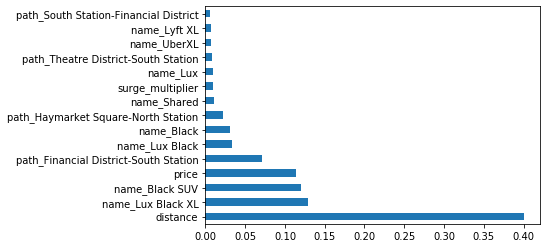

In [16]:
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_transform.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

Aside from the obvious display of price and distance, we see a few more product name categories being listed as important features for price_per_mile. The names are Lux Black XL, Black SUV, Lux Black, Black, Shared, Lux, UberXL and Lyft XL. As for path, only 4 paths are listed as important here, which are Financial District to South Station, Haymarket Square to North Station, Theatre District to South Station and South Station to Financial District.

Let's summarise the results based on the original columns. The selected features are different from previously, which are:

1. **distance**
2. **name**
3. **price**
4. **path**
5. **surge multiplier**

## Modeling using Pycaret

PyCaret is an all in one machine learning library that is convenient and easy to implement with tons of useful features. Before we can train and test any models, it is mandatory to set up the environment for PyCaret to perform modeling on the required dataset. 

### Setting Up the Pycaret Environment for Modeling

In the setup() function, we can specify the operations that we wish to apply onto our dataset to suit our needs. For our Uber and Lyft dataset, we perform the following operations to setup our environment:

- **Define the size of training data**: The size of the training data is set to be 80% of the total rows of the dataset. This means that the remaining 20% will be used as the hold-out test set.
- **Define the target variable to be predicted**: The target variable to be used for regression prediction is the price_per_mile variable.
- **Define the categorical features**: In our case, we have 4 datetime related variables and 7 variables that are pure categorical variables. Datetime related variables have to be treated as categorical type because they do not display numerical meanings. The purpose of defining these features is to allow PyCaret to perform dummy/categorical encoding on them and produce binary categorical group column encodings for each group.
- **Define features to be ignored**: PyCaret allows us to list out the variables that we don't need for our modeling, such as irrelevant or some highly related variables. Since we know that price_per_mile is closely derived from price, we want to ignore price for our modeling process.
- **Define the ordinal features**: Besides, PyCaret also has a handy argument to enable the defining of ordinal features, in which for our problem, we have one that is the surge multiplier that has some correlation towards price.
- **Normalize the data**: The normalize argument is set to True because we want to normalize the numeric features to have the same range. For example, features like temperature and wind speed have very different range so it's better to normalize them. We also define the method of normalisation to be the minmax method.
- **Data shuffling**: It is common to randomly shuffle the data before modeling because we want the data to be randomised and eliminate the possibility of bias and ensure that each data point is independent to the change of the model. This is why we set the argument to be True.
- **Dialogue suppresing**: Since we are very sure about the data types for our dataset, the silent parameter is set to True to prevent PyCaret from displaying the confirmation messages of the data types. This parameter essentially does nothing but to a certain extent, setting the parameter to True can slightly speed up the setup process.
- **Feature selection**: This parameter is used to perform selection of the top features that contribute the most to the prediction of target variable, which can be output in the form of bar graphs later. When the feature_selection parameter is specified as True, PyCaret will perform selection of features using the ensemble filtering method that involves a combination of machine learning techniques. These techniques include algorithms like Random Forest, Adaboost and Linear correlation with the target feature as well. For our problem, the output feature subset size follows the default size as we did not specify the feature_selection_param parameter.

In [20]:
reg1 = setup(data = df, 
             train_size = 0.8, 
             target = "price_per_mile", 
             categorical_features = ["hour", "day", "month", "source", "destination", "cab_type", "name", "short_summary", 
                                     "long_summary", "day_of_week", "path"],
             ignore_features = ["price"], 
             ordinal_features = {"surge_multiplier": [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0]}, 
             normalize = True, 
             normalize_method = "minmax", 
             data_split_shuffle = True, 
             silent = True, 
             feature_selection = True)

,Description,Value
0,session_id,3921
1,Target,price_per_mile
2,Original Data,"(637515, 24)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,11
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(510012, 188)"


First, unlike classification problem, there is no defining of target type which means our target variable is a continuous numeric variable. Second, it is also confirmed that there are no missing values present in our dataset as displayed in the 3rd index of the table. Third, it also showed us that there are 11 numeric features and 11 categorical features, as well as the presence of ordinal features showing in the green cell at index 6. Fourth, it also displays the size and shape of transformed training and testing set, which consist of 510012 rows and 127503 rows respectively, with 188 columns as seen in the 9th and 10th index. Note that there are 3 cells (index 6, 27 and 49) being coloured in green showing that these are the parameters that we predefined in the setup function: ordinal features, normalize and feature selection.

### Comparison of Model Training Metrics

After setting up the environment, it is time to train a few models. In PyCaret, we can train multiple models at once and it will output a comparison table to display the metrics of the trained model so that we get an idea on how different models perform on the dataset. By default, the compare_models() function performs model training with **10-fold cross validation**. We won't be changing the fold number because we want to see how each model performs on 10-fold cv because it is proven that 10-fold cv works best in preventing overfitting. The function outputs a bunch of metrics including MAE, MSE, RMSE, R2, RMSLE, MAPE and Training Time in seconds (TT).

In [23]:
# Compare training metrics of a number of mahine learning models
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.5765,0.8407,0.9168,0.9857,0.0987,0.0800,49.5210
xgboost,Extreme Gradient Boosting,0.5830,0.8560,0.9251,0.9855,0.0995,0.0806,81.7440
lightgbm,Light Gradient Boosting Machine,0.6043,0.9010,0.9491,0.9847,0.1019,0.0838,3.6020
rf,Random Forest Regressor,0.5998,1.0054,1.0026,0.9829,0.1068,0.0837,621.0290
et,Extra Trees Regressor,0.6209,1.1684,1.0808,0.9801,0.1147,0.0869,985.6290
gbr,Gradient Boosting Regressor,0.7699,1.4031,1.1844,0.9762,0.1164,0.1019,139.5960
dt,Decision Tree Regressor,0.6789,1.4841,1.2181,0.9748,0.1324,0.0959,11.0890
lr,Linear Regression,1.9768,11.6606,3.4145,0.8020,0.2998,0.2511,5.7410
ridge,Ridge Regression,1.9765,11.6589,3.4143,0.8020,0.2999,0.2511,0.9540
br,Bayesian Ridge,1.9764,11.6589,3.4143,0.8020,0.2999,0.2510,6.2020


For regression, the main metrics to be examined are MAE, MSE, RMSE and R2:

- **MAE**: The Mean absolute error can be defined as the average of the absolute difference between the actual and predicted values in the dataset. It measures the **average of the residuals** in the dataset.
- **MSE**: The Mean Squared Error shows the average of the squared difference between the original and predicted values for the target variable of the data. It measures the **variance of the residuals**.
- **RMSE**: Root Mean Squared Error is the square root of Mean Squared error. It measures the **standard deviation of residuals**.
- **R2**: The coefficient of determination or R-squared represents the **proportion of the variance in the target variable which is explained by the regression model**. A value of 1 indicates perfect fit which is impossible in real dataset as it requires all the predicted values to be equal to the actual, while a value of 0 indicates that the model explains none of the variability showing that the none of the values can be predicted.

A few differences between these metrics to take note is that:

- MSE and RMSE penalises the large prediction errors due to the effect of squaring the error values compared to MAE. However, RMSE is more commonly used than MSE because it has the same units as the dependent target outcome.
- MSE is a differentiable function which makes it more interpretable and better for matematical operations compared to MAE which makes MSE a favourable option.
- MAE is more robust to the presence of outliers.

From the table above, it is observed that the first row is being highlighted in yellow, indicating that that highlighted model is the model that produces the best training result, which is the **CatBoost regressor model**. This is followed by the 2nd and 3rd best models which are the **Extreme Gradient Boosting** and **Light Gradient Boosting Machine model**. Thus, based on the results, we will build these 3 models for model testing and evaluation. 

### 1. CatBoost Regressor

In [24]:
# Build the catboost model
catboost = create_model("catboost", fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5764,0.8437,0.9186,0.9855,0.0985,0.0800
1,0.5778,0.8604,0.9276,0.9854,0.0986,0.0795
2,0.5788,0.8474,0.9205,0.9853,0.0988,0.0802
3,0.5765,0.8394,0.9162,0.9859,0.0989,0.0797
4,0.5744,0.8396,0.9163,0.9854,0.0985,0.0799
5,0.5791,0.8892,0.9430,0.9852,0.0996,0.0804
6,0.5789,0.8117,0.9010,0.9861,0.0987,0.0805
7,0.5742,0.8410,0.9171,0.9853,0.0990,0.0800
8,0.5735,0.7952,0.8918,0.9870,0.0980,0.0797
9,0.5747,0.8397,0.9163,0.9860,0.0982,0.0798


The model output after training the model shows that the mean MAE of 0.5765, MSE of 0.8407, RMSE of 0.9168, all of them are pretty low which is smaller than 1. For R2, it has a mean value of 0.9857, almost equal to 1. These metrics will be used for comparison during prediction of test set.

### Model Testing on Holdout Set

In [29]:
# Predict on hold-out/test data
predict_model(catboost)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.5768,0.8407,0.9169,0.9856,0.0990,0.0798


,short_summary_ Light Rain,path_Financial District-South Station,name_Black SUV,long_summary_ Partly cloudy throughout the day.,surge_multiplier,hour_18.0,day_14,long_summary_ Rain throughout the day.,long_summary_ Overcast throughout the day.,path_Fenway-Beacon Hill,...,path_North End-West End,day_of_week_Thursday,source_South Station,path_Beacon Hill-Fenway,path_Beacon Hill-North End,name_UberPool,path_Boston University-Theatre District,day_26,price_per_mile,Label
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.766423,11.493227
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.301887,3.263568
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.246753,3.450821
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.108359,2.263126
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.581396,25.221629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.864865,14.917922
127499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.090909,9.351250
127500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.931900,11.233610
127501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.666667,8.661876


Let's first look at the metrics of the predictions and compare one by one:

- **MAE**: When predicting values on the test set, it shows MAE of 0.5768 which is slightly higher than the mean training MAE of 0.5765.
- **MSE**: The MSE value on the test set is 0.8407 which is the same as the training MSE.
- **RMSE**: The RMSE value on the test set is 0.9169 that is slightly higher than the mean training RMSE by 0.0001.
- **R2**: We observe that the R2 produced from the test set is 0.9856, slightly smaller than the mean training R2 by 0.0001.

Overall, the training and testing metrics are very similar and do not differ much, which is a sign that our model does not overfit to the training data. It also indicates that our model can generalise well to the test data. To illustrate this, we'll pick the 1st row and the last row of the data and compare the predictions. We can see that the label predicted for the 1st row is 11.4932 compared to the actual value that is 10.7664 while the prediction for the last row is 10.5271 compared to the actual value of 10.7692. The first prediction differs by 0.7 while the last predition differs by 0.2 which are pretty good.

### Evaluate the Model

#### i. Residuals Plot

For residuals plots, basically residual is calculated by taking the observed value minus the predicted value. A residual plot is used to show the distribution/dispersion of residuals across the different predicted values on the horizontal axis. It has mainly 3 properties that makes it a good residual plot:

1. The plot has a high density of points close to the line of origin and low density of points away from the line.
2. It is symmetric about the horizontal origin line.
3. There are no clear patterns or trends exist when moving horizontally.

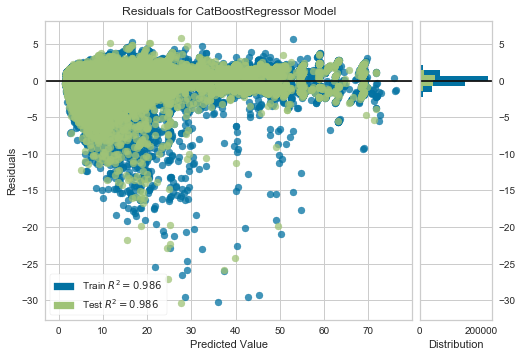

In [25]:
plot_model(estimator = catboost, plot = 'residuals')

Looking at the plot above, we can see that the points are mostly clustered to the origin line of zero. Other than a few outliers that randomly dispersed below the origin line, most of the points are around the origin line. As for the points symmetry, we can see that the distribution of the points are mostly symmetric about the origin line as shown on the right of the plot. Although there are indeed outliers that disrupts the distribution, but these outliers are very few compared to the total number of points which makes them negligible. Besides, when moving horizontally across the horizontal line, the points are seen to be randomly dispersed and no clear patterns like U shape, V shape or positive/negative can be identified. All these are good indications that our residuals plot shows good overall predictions for our model. It also tells us that the model fits really well linearly.

#### ii. Prediction Error Plot

A prediction error plot is used to compare the predicted values and actual values on the vertical and horizontal axis. In the plot, an identity line with 45 degree angle represents ideal points when predicted value matches the actual value. This plot is used to observe the variance of the predicted values by looking at the difference between the best fit line and the identity line, along with the individual point locations from the identity line. Basically, what we want is that: 

- We would want the points to be as close to the identity line as possible like a positive line, which means that we want the R2 value to be large and as close to 1 as possible. 
- We want the best fit line to be as similar to the identity line as possible.

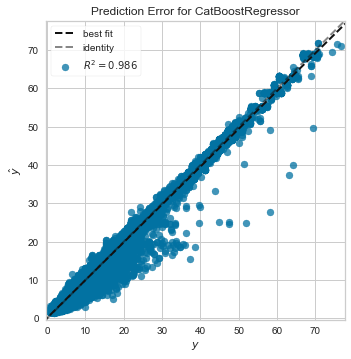

In [26]:
plot_model(estimator = catboost, plot = 'error')

Based on the graph, we can see that most of the points are following the pattern of the identity line, with some points diverging away from the identity line. In this case, the best fit line based on the data points are extremely similar to the identity line with only a very slight difference, showing a coefficient of determination (R2) value of 0.986 that is very close to 1. This means that the 98.6% of the variance of the data can be explained by the model's best fit line, which explains why the best fit line is so similar to the identity line. This is a very good fit that is almost explaining 100% of the variability of data.

#### iii. Learning Curve

A learning curve is used to assess the relationship between the training score and the cross validation score based on the increasing amount of training data. 

- It is mainly used to check if the model can take advantage of having more data, which is also an indication of whether the data is sufficient of not. 
- It is also used to see if the model's performance is affected by error due to variance or error due to bias. 

To identify if the model is suffering from variance or bias, we can check if there is any large variability around the training score (bias) or the validation score (variance). This can be observed by looking at the shaded regions around the lines.

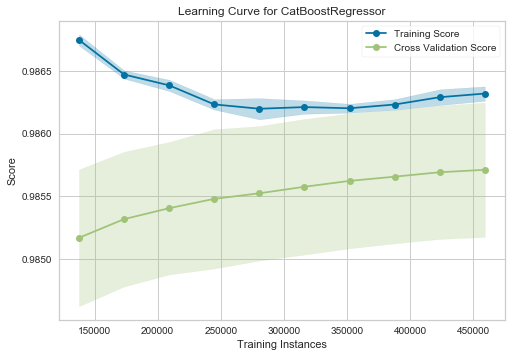

In [27]:
plot_model(estimator = catboost, plot = 'learning')

Looking at the training and cross-validation scores, we examine them based on 2 different objectives: 

- **Convergence**: There are clear signs that the lines are slowly convergence towards each other, but the lines are not fully converged yet. This means that the model can potentially benefit from adding more training data to allow the scores to converge. This is supported by the fact that the training scores are still greater than the cross-validation scores by around 0.0005.
- **Bias-Variance**: When we look at the variability of the scores, we observe that the scores for training data varies by a small but significant amount when compared to the cross-validation scores that don't vary much at all, especially at the training instances of 170000 to 250000. This is an indication that our model suffers more from error due to bias than error due to variance. Luckily for us, the degree of variability is not big enough to invoke a strong error effect to our model, implying that our model is still a pretty good model in overall that does not suffer greatly from these errors.

#### iv. Validation Curve

A validation curve is an important plot that displays how sensitive can the model's accuracy be based on changes in a certain parameter of the model. The plot is drawn with vertical axis representing the model's score and teh horizontal axis displaying the model's parameter. It shows 2 curves in which one represents the training set score and the other representing the cross-validation score. Keep in mind that this curve is not for us to tune the model, but rather to evaluate the model's performance. To interpret the plot, few points to take note:

- We want both the training and validation score curves to have pattern that are as similar as possible and also want them to be as close as possible.
- If we get low scores for both training and validation, it is very probable that the model is underfitting, which means that the model is too simple or it is regularized too much.
- If the training score reaches a high score relatively faster while the validation score curve is falling behind, then the model is overfitting, meaning that the model may be too complex and there is insufficient data. It may be the case that there is simply just too little data.
- The value of parameter where the training and validation curves are closest to each other is the parameter that we want.

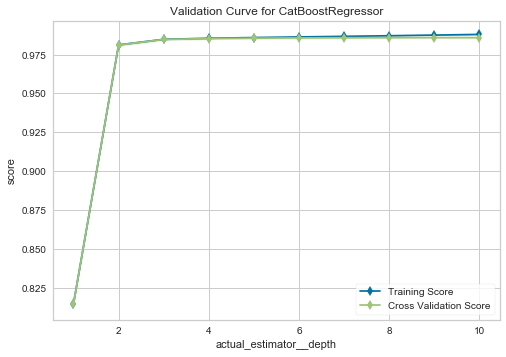

In [28]:
plot_model(estimator = catboost, plot = 'vc')

From the plot, it is very obvious to say that both training and cross-validation curves are extremely similar to each other and both scores remain very high at the same time after it passses the parameter value of 2. The actual estimator depth from 0 until 6 demonstrates both curves that almost align in the same position all the time without any signs of diverging, until they move passt the value of 6. This means that our model neither underfits nor overfits which is a really great sign. This is probably due to the 10-fold cross validation that eliminates the possibility of overfitting.

#### v. Model Hyperparameter

Viewing the model hyperparameter allows us to examine and fine tune our model especially when our model performs badly or overfits to the data. We can change certain values of the hyperparameter and benchmark the change in performance by retraining the model.

In [30]:
plot_model(estimator = catboost, plot = 'parameter')

,Parameters
nan_mode,Min
eval_metric,RMSE
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In our case, we do not need to perform hyperparameter tuning because our model has a very high R2 and very low MAE and RMSE values that exceeded our initial expectations. Generally, when your model obtains R2 that is higher than 0.9, it means your model already performs very well.

#### vi. Feature Importance

The feature importance plot shows the top 10 most important features that contribute to the results of the model predictions. It is noted that the features generated from the output includes the categorical features that have been transformed or encoded during the pre-processing that was done while executing the PyCaret setup function.

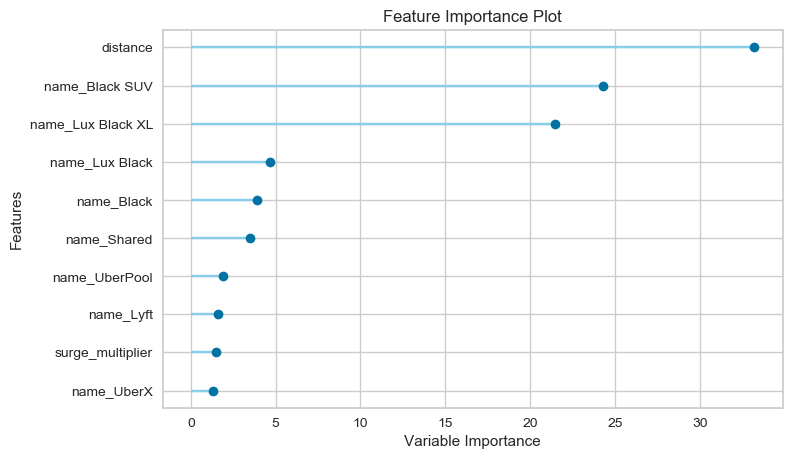

In [31]:
plot_model(estimator = catboost, plot = 'feature')

It is discovered that among the top 10 features that are displayed in the output for the CatBoost Regressor model, 8 of them are derived from the same categorical feature, that is the name column representing the product groups offered by the cab services, while the 1st and 9th feature are distance and surge multiplier respectively. This shows that distance and name are the two most important feature from the original columns, followed by surge_multiplier column. Note that distance, name_Black SUV and name_Lux Black XL have much greater scores compared to the remaining 7 features.

### 2. Extreme Gradient Boosting

In [32]:
# Build the xgboost model
xgboost = create_model('xgboost', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5832,0.8604,0.9276,0.9852,0.0994,0.0807
1,0.5846,0.8790,0.9375,0.9850,0.0994,0.0801
2,0.5857,0.8660,0.9306,0.9850,0.0997,0.0809
3,0.5843,0.8530,0.9236,0.9857,0.0997,0.0805
4,0.5827,0.8592,0.9269,0.9851,0.0994,0.0807
5,0.5854,0.9023,0.9499,0.9850,0.1005,0.0811
6,0.5823,0.8248,0.9082,0.9859,0.0994,0.0809
7,0.5814,0.8531,0.9236,0.9851,0.0997,0.0807
8,0.5789,0.8062,0.8979,0.9868,0.0986,0.0802
9,0.5818,0.8560,0.9252,0.9857,0.0989,0.0806


Based on the output after training the model, it shows that the mean MAE of 0.5830, MSE of 0.8560, RMSE of 0.9251, all of them are very low which are smaller than 1. As for R2 value, it has a mean value of 0.9855, also very close to 1. As usual, these metrics will be used for comparison during model testing.

### Model Testing on Holdout Set

In [33]:
# Predict on hold-out/test data
predict_model(xgboost)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.5836,0.8565,0.9254,0.9853,0.0999,0.0808


,short_summary_ Light Rain,path_Financial District-South Station,name_Black SUV,long_summary_ Partly cloudy throughout the day.,surge_multiplier,hour_18.0,day_14,long_summary_ Rain throughout the day.,long_summary_ Overcast throughout the day.,path_Fenway-Beacon Hill,...,path_North End-West End,day_of_week_Thursday,source_South Station,path_Beacon Hill-Fenway,path_Beacon Hill-North End,name_UberPool,path_Boston University-Theatre District,day_26,price_per_mile,Label
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.766423,11.516537
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.301887,3.347265
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.246753,3.398508
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.108359,2.216420
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.581396,25.169872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.864865,14.950005
127499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.090909,9.180928
127500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.931900,11.265246
127501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.666667,8.671831


Like the first model, we'll look at the metrics of the predictions and compare one by one:

- **MAE**: When predicting values on the test set, it shows MAE of 0.5836 which is slightly higher than the mean training MAE of 0.5830.
- **MSE**: The MSE value on the test set is 0.8565 which is also slightly higher than the training MSE that is 0.8560.
- **RMSE**: The RMSE value on the test set is 0.9254 that is slightly higher than the mean training RMSE by 0.0003.
- **R2**: We observe that the R2 produced from the test set is 0.9853, slightly smaller than the mean training R2 by 0.0002.

Overall, the training and testing metrics are very similar and do not differ much, which is a good indication that the model does not overfit to the training data. It also implies that our model can generalise well to the test data. As a example, we'll pick the 1st row and the last row of the data and compare the predictions. We can see that the label predicted for the 1st row is 11.5165 compared to the actual value that is 10.7664 while the prediction for the last row is 10.6106 compared to the actual value of 10.7692. The first prediction differs by around 0.7 while the last predition differs by around 0.2 which are pretty good.

### Evaluate the Model

#### i. Residuals Plot

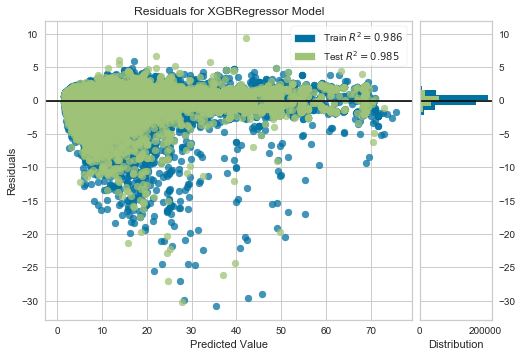

In [34]:
plot_model(estimator = xgboost, plot = 'residuals')

Similar to the CatBoost regressor model, we note that the points are also mostly clustered to the origin line of zero. Other than a few outliers that randomly dispersed below the origin line, most of the points are around the origin line. As for the points symmetry, we can see that the distribution of the points are mostly symmetric about the origin line as shown on the right of the plot. Like the previous model, there are outliers that disrupts the distribution, but these outliers are very few compared to the total number of points which makes them negligible. Moreover, when moving horizontally across the horizontal line, the points are seen to be randomly dispersed and no clear patterns like U shape, V shape or positive/negative can be identified. We obtain good indications that our residuals plot shows good overall predictions for our model. It also tells us that the model fits really well linearly, just like the previous model.

#### ii. Prediction Error Plot

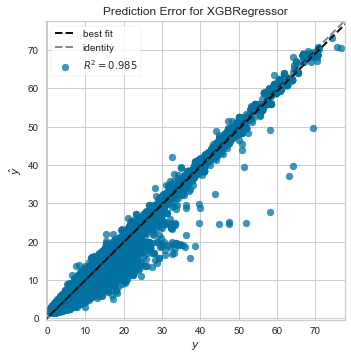

In [35]:
plot_model(estimator = xgboost, plot = 'error')

From the graph, we can see that most of the points are following the pattern of the identity line, with some points diverging away from the identity line. In this case, the best fit line based on the data points are extremely similar to the identity line with only a very slight difference, showing a coefficient of determination (R2) value of 0.985 that is very close to 1, similar to CatBoost regressor model. Interpreting this means that the 98.5% of the variance of the data can be explained by the model's best fit line, which explains why the best fit line almost aligns with the identity line. Like the previous modle, this is also a very good fit that is almost explaining 100% of the data variations.

#### iii. Learning Curve

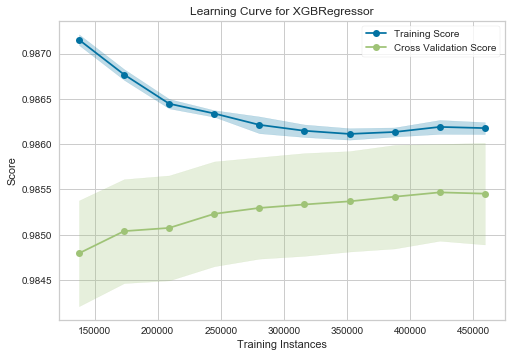

In [36]:
plot_model(estimator = xgboost, plot = 'learning')

To break the learning curve down for evaluation, we examine the plot based on 2 different objectives: 

- **Convergence**: There are obvious signs that the lines are slowly convergence towards each other, but the lines are not fully converged yet. It is an indication that the model can probably benefit from adding more training data to allow the scores to converge. This is supported by the fact that the training scores are still greater than the cross-validation scores by around 0.0005.
- **Bias-Variance**: Based on the variability of the scores, we observe that the scores for training data are pretty consistent while the cross-validation scores have some variations present at the training instances of 170000 to 250000. To explain this, it tells us that our model suffers more from error due to variance than error due to bias. Fortunately, the degree of variability is not big enough to invoke a big impact to our model, implying that our model is still a great model in overall that does not suffer greatly from these errors.

#### iv. Validation Curve

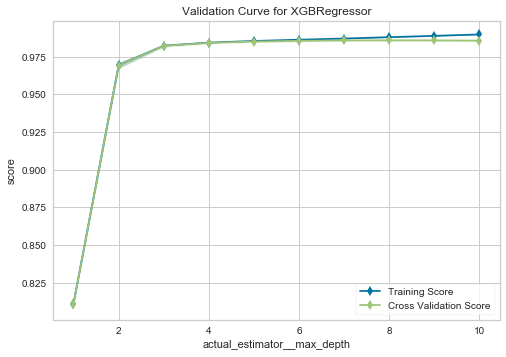

In [37]:
plot_model(estimator = xgboost, plot = 'vc')

For the XGBoost model, we obtain extremely similar results just like the CatBoost model. It is clear that both training and cross-validation curves are extremely similar to each other and both scores remain very high at the same time after it passses the parameter value of 2. Similarly, the actual estimator depth from 0 until 6 shows both curves that almost align in the same position all the time without any signs of diverging, until after the value of 6. This means that our model neither underfits nor overfits which is a really great sign. We get the same feeling that this is thanks to the 10-fold cross-validation that helps to prevent overfitting.

#### v. Model Hyperparameter

In [38]:
plot_model(estimator = xgboost, plot = 'parameter')

,Parameters
objective,reg:squarederror
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
gamma,0
gpu_id,-1
importance_type,gain
interaction_constraints,


There is no need to perform hyperparameter tuning because our model has a very high R2 and very low MAE and RMSE values that also fulfill our initial expectations. The model has very good performance with R2 value higher than 0.9 which is better than what we can imagine.

#### vi. Feature Importance

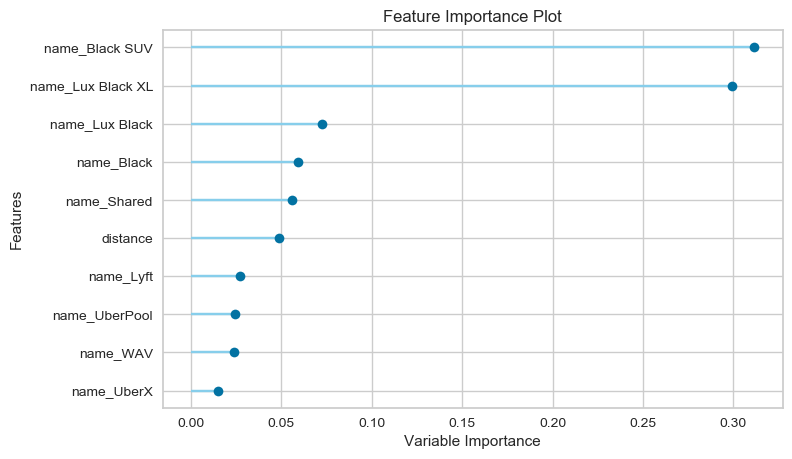

In [39]:
plot_model(estimator = xgboost, plot = 'feature')

In comparison, among the top 10 features that are displayed in the output for the XGBoost model, 9 of them are derived from the same categorical feature, that is the name column representing the product groups offered by the cab services. The only feature that are not related to product name is the distance feature located at the 6th place. This shows that distance and name are the two most important feature from the original columns which tells us that the model behaves pretty similar to CatBoost model. Note that name_Black SUV and name_Lux Black XL have much greater scores compared to the remaining 8 features.

### 3. Light Gradient Boosting Machine

In [40]:
# Build the lightgbm model
lightgbm = create_model('lightgbm', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6028,0.9000,0.9487,0.9846,0.1018,0.0838
1,0.6069,0.9269,0.9627,0.9842,0.1020,0.0834
2,0.6045,0.9021,0.9498,0.9844,0.1020,0.0840
3,0.6073,0.8986,0.9480,0.9849,0.1023,0.0839
4,0.6036,0.9108,0.9544,0.9842,0.1017,0.0837
5,0.6052,0.9404,0.9697,0.9844,0.1027,0.0843
6,0.6022,0.8643,0.9297,0.9852,0.1015,0.0838
7,0.6059,0.9082,0.9530,0.9841,0.1022,0.0843
8,0.6021,0.8524,0.9233,0.9861,0.1010,0.0837
9,0.6024,0.9067,0.9522,0.9849,0.1014,0.0836


The results after training the lightgbm model shows that the mean MAE is 0.6043, with MSE of 0.9010 and RMSE of 0.9491, all of them are pretty low which are smaller than 1. The last metric to observe that is R2 shows a mean value of 0.9847, almost equal to 1 as well. These metrics will be used for comparison during prediction of test set.

### Model Testing on Holdout Set

In [41]:
# Predict on hold-out/test data
predict_model(lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6053,0.9005,0.9490,0.9845,0.1022,0.0837


,short_summary_ Light Rain,path_Financial District-South Station,name_Black SUV,long_summary_ Partly cloudy throughout the day.,surge_multiplier,hour_18.0,day_14,long_summary_ Rain throughout the day.,long_summary_ Overcast throughout the day.,path_Fenway-Beacon Hill,...,path_North End-West End,day_of_week_Thursday,source_South Station,path_Beacon Hill-Fenway,path_Beacon Hill-North End,name_UberPool,path_Boston University-Theatre District,day_26,price_per_mile,Label
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.766423,11.407634
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.301887,3.345349
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.246753,3.380480
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.108359,2.280479
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.581396,24.761663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.864865,15.204867
127499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.090909,9.438145
127500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.931900,11.279032
127501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.666667,9.064682


For the last model, we'll look at the metrics of the predictions and compare one by one repeating the steps for the previous models:

- **MAE**: When predicting values on the test set, it shows MAE of 0.6053 which is slightly higher than the mean training MAE of 0.6043.
- **MSE**: The MSE value on the test set is 0.9005 which is slightly lower than the training MSE that is 0.9010.
- **RMSE**: The RMSE value on the test set is 0.9490 that is also slightly smaller than the mean training RMSE by 0.0001.
- **R2**: We observe that the R2 produced from the test set is 0.9845, slightly smaller than the mean training R2 by 0.0002.

In summary, the training and testing metrics are very similar and do not vary significantly, which is a positive indication that the model does not overfit to the training data. In other words, it means that our model can generalise well to the test data. Like previously, we'll pick the 1st row and the last row of the data and compare the predictions. We can see that the label predicted for the 1st row is 11.4076 compared to the actual value that is 10.7664 while the prediction for the last row is 10.8784 compared to the actual value of 10.7692. The first prediction differs by around 0.7 while the last predition differs by around 0.1 which are far from bad.

#### i. Residuals Plot

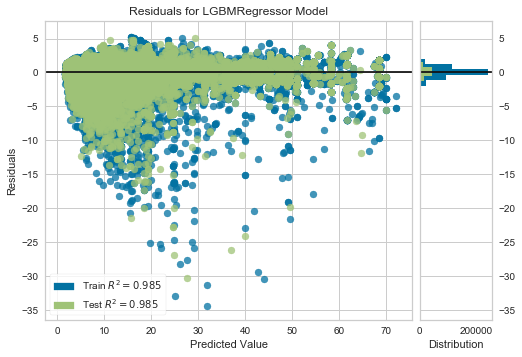

In [42]:
plot_model(estimator = lightgbm, plot = 'residuals')

Same goes to this model, we note that the points are also mostly clustered to the origin line of zero. Aside from a few outliers that randomly dispersed below the origin line, most of the points are around the origin line. As for the points symmetry, we can see that the distribution of the points are mostly symmetric about the origin line as shown on the right of the plot. We could not ignore the fact that there are outliers that disrupts the distribution, but these outliers are very few compared to the total number of points which can be neglected. Furthermore, when moving horizontally across the horizontal line, the points are clearly dispersed randomly and we see no clear patterns like U shape, V shape or positive/negative can be identified. We obtain good indications that our residuals plot shows good overall predictions for our model. It also tells us that the model fits really well linearly, just like the past 2 models.

#### ii. Prediction Error Plot

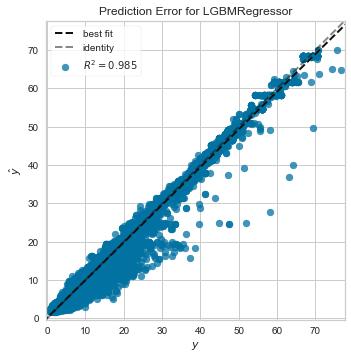

In [43]:
plot_model(estimator = lightgbm, plot = 'error')

Intepreting the graph, we found that most of the points are following the pattern of the identity line, with some points diverging away from the identity line. We see that the best fit line based on the data points is extremely similar to the identity line with only a very slight difference, showing a coefficient of determination (R2) value of 0.985 that is very close to 1, similar to the previous models. Similarly, the plot shows that 98.5% of the variance of the data can be explained by the model's best fit line, which is the reason why the best fit line almost aligns with the identity line. Like the previous models, this is also a very good fit that is almost explaining 100% of the data variations.

#### iii. Learning Curve

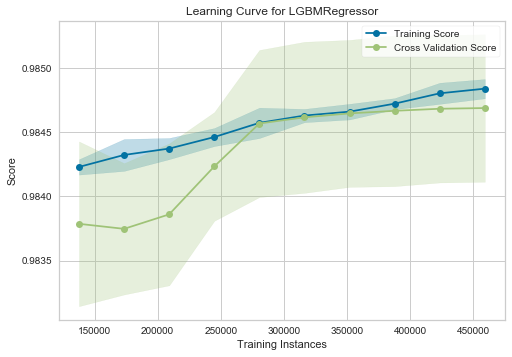

In [44]:
plot_model(estimator = lightgbm, plot = 'learning')

Contrary to the previous models, this learning curve behaves quite differently with some points to be discussed:

- **Convergence**: There are obvious signs that the lines are converging towards each other, and the difference is that these lines converge at the training instances of around 280000. As a result, this model will not be able to benefit much from more training data as opposed to what we saw in the previous learning curves.
- **Bias-Variance**: Based on the variability of the scores, we observe that the scores for training data are pretty consistent while the cross-validation scores have some pretty big variations present at the training instances of 170000 to 280000. This tells us that our model suffers more from error due to variance instead of bias. However, our model is still a good model in overall that does not suffer greatly from these errors.

#### iv. Validation Curve

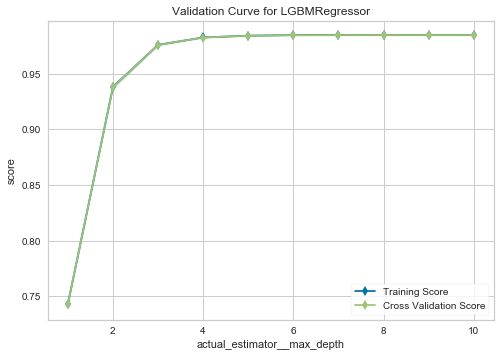

In [45]:
plot_model(estimator = lightgbm, plot = 'vc')

For the Light GBM model, we obtain extremely similar results just like the CatBoost and XGBoost model. Other than the depth point of 4, the rest of the depth parameter shows that both training and cross-validation curves are just identical to each other and both scores remain very high at the same time after it passses the parameter value of 2. We can observe that actual estimator depth shows both curves that almost align in the same position all the time without any signs of diverging. This means that our model neither underfits nor overfits which is a really great sign. Like before, we think that this is thanks to the 10-fold cross-validation that helps to prevent overfitting.

#### v. Model Hyperparameter

In [46]:
plot_model(estimator = lightgbm, plot = 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


For this model, hyperparameter tuning is also not strictly required because our model has a very high R2 and very low MAE and RMSE values that performed better than what we perceive. The model has very good performance on the test data with R2 value higher than 0.9 which is a sign that it is quite ready for production.

#### vi. Feature Importance

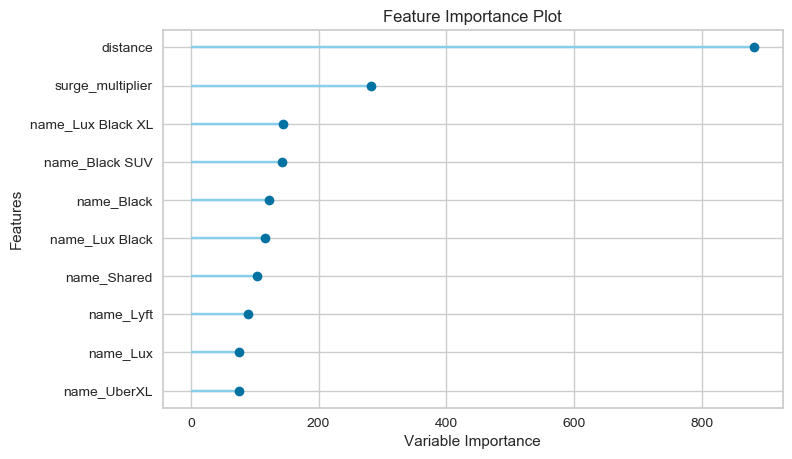

In [47]:
plot_model(estimator = lightgbm, plot = 'feature')

Based on the scores, among the top 10 features that are displayed in the output for the XGBoost model, 8 of them are derived from the same categorical variable, that is the name column representing the product groups offered by Uber and Lyft. This result is pretty similar to the CatBoost model. Two features that are not under the name column is distance and surge multiplier on the 1st and 2nd row. This shows that distance and surge multiplier are the two most important feature from the original columns, followed by name which acts pretty similar to CatBoost model. Take note that distance has much greater scores compared to the remaining 9 features.

## Final Model to Choose

To conclude our evaluation, the **CatBoost Regressor model** is chosen as the final best model. This is because:

- The model has the highest average R2 value of 0.9856 when used for prediction on the holdout test set.
- The errors for this model are the lowest: It has MAE of 0.5768, MSE of 0.8407 and RMSE of 0.9169.
- The model doesn't suffer much from errors due to bias or variance which means the model doesn't underfit or overfit.

### Machine Learning Summary:

The prediction of price rate of Uber and Lyft can be evaluated through various machine learning models such as **CatBoost Regressor, Extreme Gradient Boosting** and **Light Gradient Boosting Machine model**, in which all of them show MAE and RMSE of less than 1, as well as high coefficient of determination (R2) value of more than 0.98.

## Reference Websites

- Error metrics: https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e
- Prediction error plot: https://www.scikit-yb.org/en/latest/api/regressor/peplot.html#:~:text=A%20prediction%20error%20plot%20shows,values%20generated%20by%20our%20model.&text=Data%20scientists%20can%20diagnose%20regression,prediction%20exactly%20matches%20the%20model.
- Learning curve: https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
- Validation curve: https://www.geeksforgeeks.org/validation-curve/